In [1]:
import numpy as np
import pickle

from sr_gp_methods import gp, gpshap, gpcmi, new_method
from datasets import load_datasets
from pysr_utils import results_to_dataframe, plot_results, nrmse_loss, train_val_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

sns.set_theme()
warnings.filterwarnings("ignore", category=UserWarning, module="pysr")
warnings.filterwarnings("ignore", category=RuntimeWarning)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
dataset_names = [
    "F1",
    # "F2",
    # ("4544_GeographicalOriginalofMusic", "4544_GOM"),
    # "505_tecator",
    # ("Communities and Crime", "CCN"),
    # ("Communities and Crime Unnormalized", "CCUN"),
]

datasets = load_datasets(dataset_names)
width = max([round(len(name)+10, -1) for name in datasets.keys()])

datasets.keys()

dict_keys(['F1'])

In [114]:
n_submodels = 2
n_runs = 10
test_size = 0.2
val_size = 0.25

pysr_params = {
    "populations": 1,
    "population_size": 20,
    "niterations": 50,
    "binary_operators": ["+", "-", "*"],
    "unary_operators": ["sqrt", "inv(x) = 1/x"],
    "extra_sympy_mappings": {"inv": lambda x: 1/x},
    "verbosity": 0
}

cmi_fs_params = {
    "k": 5,
    "alpha": 0.01,  # Significance level for CMI
}

basic_params = {
    "loss_function": nrmse_loss,
    "record_interval": 5,
    "pysr_params": pysr_params
}

In [115]:
from inspect import signature
from pysr import PySRRegressor
from typing import Callable
from pysr_utils import cumulative_lambda
from copy import deepcopy

def new_method(
    method_params: dict,
    n_submodels: int = 2,
    method_function: Callable = gpcmi,
) -> tuple[dict, list, list]:
    
    method_params = deepcopy(method_params)

    if ('pysr_params' not in method_params) or (method_params['pysr_params'] is None):
        niterations = signature(PySRRegressor).parameters['niterations'].default
        method_params['pysr_params'] = {}
    else:
        niterations = method_params['pysr_params'].get("niterations", signature(PySRRegressor).parameters['niterations'].default)
    
    record_interval = method_params.get("record_interval", signature(method_function).parameters['record_interval'].default)
    n_records = niterations // record_interval
    n_runs = len(method_params['train_val_test_sets_list'])

    results = {
        "training_loss": np.zeros((n_runs, n_records)),
        "validation_loss": np.zeros((n_runs, n_records)),
        "test_loss": np.zeros((n_runs, n_records))
    }
    selected_features_list = [[] for _ in range(n_runs)]
    best_eqs_lists = [[] for _ in range(n_runs)]
    lambda_models = [[] for _ in range(n_runs)]
    lambda_exprs = [[] for _ in range(n_runs)]

    train_val_test_sets_list_original = method_params['train_val_test_sets_list'].copy()

    for sub_i in range(n_submodels):
        submethod_name = f"{method_function.__name__}_{sub_i+1}/{n_submodels}"
        print(f"{submethod_name+' ':-<20}")

        low = sub_i * n_records // n_submodels
        high = (sub_i + 1) * n_records // n_submodels
        n_points = high - low

        method_params['pysr_params']['niterations'] = n_points * record_interval

        # Run the method function
        _, temp_selected_features_list, temp_best_eqs_list = method_function(**method_params)

        for run in range(n_runs):
            selected_features = temp_selected_features_list[run]
            interval_best_eqs = temp_best_eqs_list[run]

            selected_features_list[run].append(selected_features)
            best_eqs_lists[run].append(interval_best_eqs)
            lambda_exprs[run] = [best_eq.lambda_format for best_eq in interval_best_eqs]
            
            if sub_i == 0:
                temp_lambda_model = [None]
            else:
                temp_lambda_model = lambda_models[run].copy()
                temp_lambda_model.append((lambda_exprs[run][-1], selected_features))

            X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_sets_list_original[run]

            for interval_idx in range(low, high):
                temp_lambda_model[-1] = (lambda_exprs[run][interval_idx - low], selected_features)
                # lambda_models[run][interval_idx].append((lambda_exprs[run][interval_idx - low], selected_features))

                # Compute cumulative predictions from current submodels
                # train_cumulative_pred = cumulative_lambda(X_train, lambda_models[run][interval_idx])
                # val_cumulative_pred = cumulative_lambda(X_val, lambda_models[run][interval_idx])
                # test_cumulative_pred = cumulative_lambda(X_test, lambda_models[run][interval_idx])
                train_cumulative_pred = cumulative_lambda(X_train, temp_lambda_model)
                val_cumulative_pred = cumulative_lambda(X_val, temp_lambda_model)
                test_cumulative_pred = cumulative_lambda(X_test, temp_lambda_model)

                # Compute losses for cumulative predictions
                results["training_loss"][run, interval_idx] = method_params['loss_function'](
                    y_train, train_cumulative_pred
                )
                results["validation_loss"][run, interval_idx] = method_params['loss_function'](
                    y_val, val_cumulative_pred
                )
                results["test_loss"][run, interval_idx] = method_params['loss_function'](
                    y_test, test_cumulative_pred
                )
            
            lambda_models[run].extend(temp_lambda_model)
            
            # for interval_idx in range(high+1, n_records):
            #     lambda_models[run][interval_idx].append((lambda_exprs[run][-1][interval_idx - high+1], selected_features))

            X_train_curr = X_train[selected_features]
            X_val_curr = X_val[selected_features]
            X_test_curr = X_test[selected_features]

            y_train_residual, y_val_residual, y_test_residual = method_params['train_val_test_sets_list'][run][3:]

            y_train_residual -= lambda_exprs[run][-1](X_train_curr)
            y_val_residual -= lambda_exprs[run][-1](X_val_curr)
            y_test_residual -= lambda_exprs[run][-1](X_test_curr)

            method_params['train_val_test_sets_list'][run] = (
                X_train, 
                X_val, 
                X_test, 
                y_train_residual, 
                y_val_residual, 
                y_test_residual
            )

    return results, selected_features_list, best_eqs_lists

In [116]:
features['F1']['gpNEW'][0]

[['X2', 'X1', 'X3', 'noise_26', 'noise_2', 'noise_20'],
 ['X3', 'noise_17', 'X1', 'X2', 'noise_16']]

In [124]:
equations['F1']['gpNEW'][1][0][-1].sympy_format                                 

-1.0418755e-11*X2*(X1 + 1.1955408)

In [118]:
results = {}
features = {}
equations = {}

for dataset_name, dataset in datasets.items():
    title = f"{dataset_name}"
    print("*" * width)
    print(f"|{title.center(width - 2)}|")
    print("*" * width)
    
    X = dataset['X']
    y = dataset['y']

    train_val_test_sets_list = [
        train_val_test_split(
            X=X,
            y=y,
            test_size=test_size,
            val_size=val_size
        ) for _ in range(n_runs)
    ]

    basic_params.update({"train_val_test_sets_list" : train_val_test_sets_list})

    results[dataset_name] = {}
    features[dataset_name] = {}
    equations[dataset_name] = {}

    # Run GP and store results
    results[dataset_name]['GP'], features[dataset_name]['GP'], equations[dataset_name]['GP'] = gp(**basic_params)
    
    # # Run GPSHAP and store results
    # results[dataset_name]['GPSHAP'], features[dataset_name]['GPSHAP'], equations[dataset_name]['GPSHAP'] = gpshap(
    #     gp_best_equations=equations[dataset_name]['GP'],
    #     **basic_params
    # )

    # Run GPCMI and store results
    results[dataset_name]['gpCMI'], features[dataset_name]["gpCMI"], equations[dataset_name]["gpCMI"] = gpcmi(
        fs_params=cmi_fs_params,
        **basic_params,
    )

    # # Run new_method and store results
    results[dataset_name]['gpNEW'], features[dataset_name]["gpNEW"], equations[dataset_name]["gpNEW"] = new_method(
        {
            "fs_params":cmi_fs_params,
            **basic_params, 
        },
        n_submodels=n_submodels,
        method_function=gpcmi,
    )

    print()

**********
|   F1   |
**********
GP -----------------


GP : 100%|██████████| 10/10 [00:00<?, ?it/s]


gpCMI --------------


gpCMI : 100%|██████████| 10/10 [00:00<00:00, 9946.18it/s]


gpcmi_1/2 ----------
gpCMI --------------


gpCMI : 100%|██████████| 10/10 [00:00<00:00, 9991.20it/s]


gpcmi_2/2 ----------
gpCMI --------------


gpCMI : 100%|██████████| 10/10 [00:00<?, ?it/s]



Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [ ]:
# data = (results, features, equations)
# pickle.dump(data, open("data.pickle", "wb"))
# results, features, equations = pickle.load(open("data.pickle", "rb"))

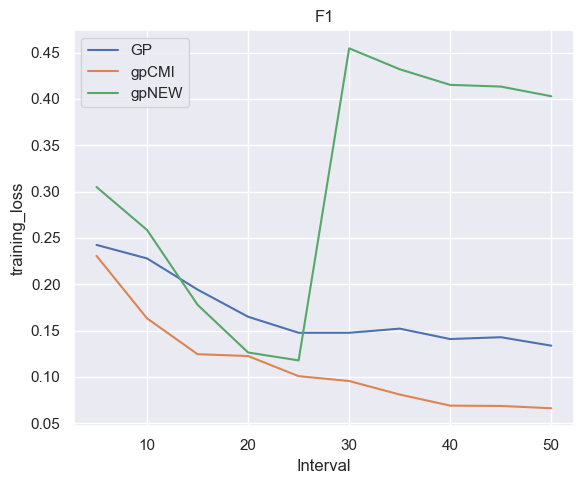

In [119]:
metrics = 'training_loss'
# metrics = 'validation_loss'
# metrics = 'test_loss'
n_datasets = len(results)
record_interval = basic_params['record_interval']
fig, axes = plt.subplots(1, n_datasets, figsize=(6 * n_datasets, 5))

if n_datasets == 1:
    axes = [axes]  # Ensure axes is always iterable

for ax, (dataset_name, dataset_results) in zip(axes, results.items()):
    # Get the number of intervals from any method (they should all be the same)
    method = next(iter(dataset_results))
    length = len(dataset_results[method][metrics].mean(axis=0))

    for method in dataset_results.keys():
        ax.plot(
            range(record_interval, length * record_interval + 1, record_interval),
            np.nanmedian(dataset_results[method][metrics], axis=0),
            label=method
        )
    ax.set_title(dataset_name)
    ax.set_xlabel("Interval")
    # ax.set_yscale("log")
    ax.legend()

axes[0].set_ylabel(metrics)
plt.tight_layout()

plt.show()

In [112]:
from copy import deepcopy

results_copy = deepcopy(results)

for dataset_name in results.keys():
    for method in results[dataset_name].keys():
        for metric in results[dataset_name][method].keys():
            results_copy[dataset_name][method][metric] = results[dataset_name][method][metric][:, -1]

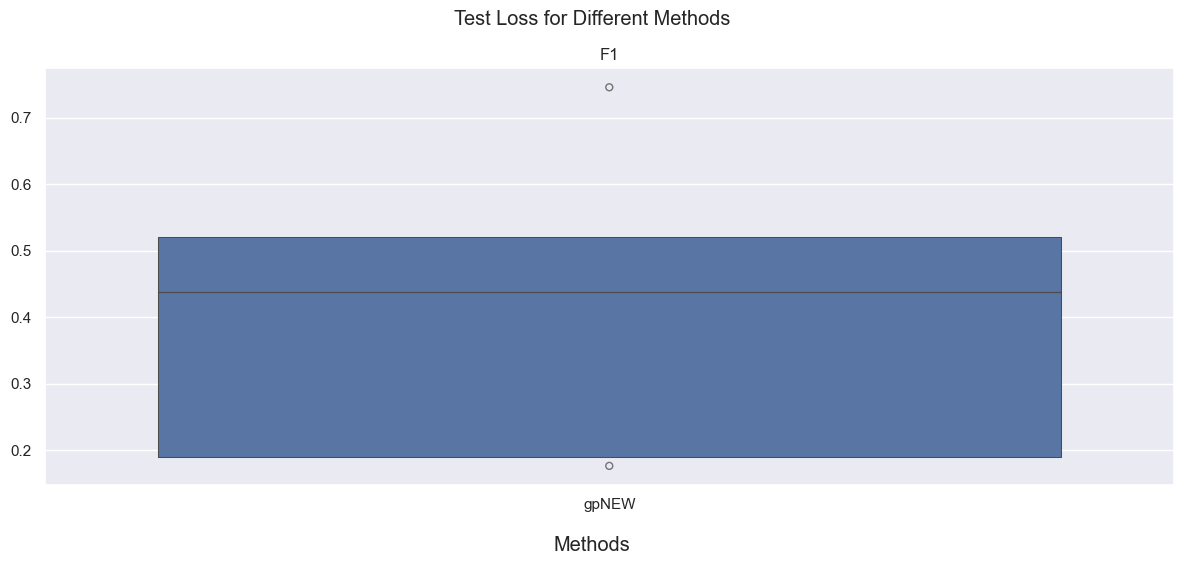

In [113]:
# Convert results to DataFrame    
df_results = results_to_dataframe(results_copy)

fig, axes = plot_results(
    df_results, 
    # nrows=2, 
    # ncols=None, 
    # group_level="model",
    # value_level="metric", 
    # value_key="test_loss"
    # value_key="validation_loss",
    # value_key="training_loss"
)

fig.figure.set_size_inches(12, 5)
fig.tight_layout(w_pad=0.5)
fig.suptitle("Test Loss for Different Methods", y=1.04)
# fig.supylabel("Test Loss", x=-.02)
fig.supxlabel("Methods", y=-.05)

# axes[0].set_ylim(-.001, 0.2)
# axes[1].set_ylim(.1, 0.2)
plt.show()

In [18]:
for dataset_name in features.keys():
    print(f"{dataset_name} features:")
    for method in features[dataset_name].keys():
        a = features[dataset_name][method]

        if isinstance(a[0], str):
            print(f"{method}: {len(a)}")
        else:

            if isinstance(a[0][0], str):
                b = list(map(lambda x: len(x), a))
                mean_x = np.mean(b)
            else:
                c = list(map(lambda x: len(set([item for sublist in x for item in sublist])), features[dataset_name][method]))
                mean_x = np.mean(c)

            print(f"{method}: {mean_x:.0f}")
    print()
            

CCUN features:
GP: 124
gpCMI: 12
gpNEW: 27



In [20]:
features['CCUN']['gpNEW']

[[['pctKidsBornNevrMarr',
   'pctAllDivorc',
   'pctBornStateResid',
   'pctEmploy',
   'pctWhite',
   'pctFgnImmig_5',
   'medOwnCostpct',
   'pctSmallHousUnits',
   'policCallPerOffic',
   'pctVacant6up',
   'pctOfficDrugUnit',
   'persPerFam',
   'policCarsAvail',
   'asianPerCap',
   'pct2Par'],
  ['pctKidsBornNevrMarr',
   'pctAllDivorc',
   'pctSameHouse_5',
   'rentQrange',
   'pctFgnImmig_5',
   'pctImmig_3',
   'pctHousOccup',
   'pctHousWOphone',
   'medOwnCostPctWO',
   'ownHousQrange']],
 [['pctKidsBornNevrMarr',
   'policCallPerOffic',
   'medFamIncome',
   'pctWhite',
   'pctMaleDivorc',
   'pct2Par',
   'persPerOwnOccup',
   'pctPolicWhite',
   'pctNotHSgrad',
   'policCallPerPop'],
  ['pctKidsBornNevrMarr',
   'pctEmploy',
   'medOwnCostPctWO',
   'pctFgnImmig_8',
   'policCallPerOffic',
   'pctPolicAsian',
   'pctHousOccup',
   'policAveOT',
   'pctWhite',
   'pctAllDivorc',
   'medYrHousBuilt',
   'NAperCap',
   'pctCollGrad',
   'pctFgnImmig_10']],
 [['pctKidsBornNev

In [ ]:
features['F1']['gpCMI'][4]

In [ ]:
ff = equations['505_tecator']['GPSHAP'][29].sympy_format
ff

In [ ]:
sym_list = [str(sym) for sym in ff.free_symbols]
w = datasets['505_tecator']['X']#[sym_list]
w.head()

In [ ]:
z = w[w['absorbance_83'] + w['principal_component_3'] < 0]
z['absorbance_83'] + z['principal_component_3']

In [ ]:
features['F1']['GPSHAP']

In [ ]:
print(results['F1']['GPSHAP']['test_loss'][7][-1])

In [ ]:
a = {"a":1, "b":2, "c":3}

# check if "d" is in a else set it
# if "d" not in a:
#     a["d"] = 4

a

In [ ]:
a['d']

In [ ]:
sympy_expr = equations['F1']['GP'][8].sympy_format
print(sympy_expr)
print(sympy_expr.simplify())
print(sympy_expr.simplify().free_symbols)
print(sympy_expr.free_symbols)
expr_variables = sorted(sympy_expr.free_symbols, key=lambda s: str(s))
print(expr_variables)

In [ ]:
from typing import Callable, Optional
import numpy as np
from sympy import lambdify
from shap import SamplingExplainer, utils

def _lambda_func_shap(
    X: np.ndarray, 
    lambda_func: Callable
) -> np.ndarray:
    """
    Helper function to apply a sympy lambdified function to a 2D numpy array X,
    unpacking columns as separate arguments.

    Parameters
    ----------
    X : np.ndarray
        2D array of shape (n_samples, n_features).
    lambda_func : callable
        Function returned by sympy.lambdify, expecting each feature as a separate argument.

    Returns
    -------
    np.ndarray
        The result of applying lambda_func to X.
    """
        
    # Unpack each column of X as a separate argument to lambda_func
    return lambda_func(*[X[:, i] for i in range(X.shape[1])])

def shap_feature_selection(
    n_top_features: int,
    X_train_list: Optional[tuple],
    gp_best_equations: Optional[list]
) -> tuple[list[str], list[float], tuple]:
    
    # Initialize SHAP value aggregation
    mean_shap_values = {}
    n_equations = len(gp_best_equations)

    # Process each equation to compute SHAP values
    for gp_best_equation, X_train in zip(gp_best_equations, X_train_list):
        # Convert GP equation to sympy format and extract variables
        sympy_expr = gp_best_equation.sympy_format
        expr_variables = sorted(sympy_expr.free_symbols, key=lambda s: str(s)) # TODO: I dont know why I short
        
        # Skip equations with no variables
        if len(expr_variables) >= 1:
            # Create numpy-compatible lambda function from sympy expression
            lambda_func = lambdify(expr_variables, sympy_expr, modules="numpy")
            str_variables = [str(var) for var in expr_variables]

            print(X_train.shape)
            
            # Sample data for SHAP analysis
            # Background data provides baseline for SHAP explanations
            X_background = utils.sample(X_train[str_variables], 100, random_state=None)
            # Foreground data is what we want to explain
            X_foreground = utils.sample(X_train[str_variables], 1000, random_state=None)

            # Create SHAP explainer for the equation function
            explainer = SamplingExplainer(
                lambda X: _lambda_func_shap(X, lambda_func),
                X_background
            )

            # Compute SHAP values for each feature in the equation
            shap_values = explainer.shap_values(X_foreground, silent=True)
            # Use absolute values and average across samples to get feature importance
            feature_shap_values = np.mean(shap_values, axis=0)
            # feature_shap_values = np.abs(shap_values).mean(axis=0)

            # Aggregate SHAP values across equations (normalize by number of equations)
            for feature_shap_value, var_name in zip(feature_shap_values, str_variables):
                mean_shap_values[var_name] = mean_shap_values.get(var_name, 0) + feature_shap_value/n_equations

    # Select top features by mean SHAP value
    selected_features = sorted(mean_shap_values, key=mean_shap_values.get, reverse=True)[:n_top_features]
    mean_shap_values_selected_features = [mean_shap_values[feature] for feature in selected_features]

    return selected_features, mean_shap_values_selected_features

In [ ]:
X_train_list = [train_val_test_sets[0] for train_val_test_sets in train_val_test_sets_list]

a, b = shap_feature_selection(
    n_top_features=X_train_list[0].shape[1],
    X_train_list=X_train_list,
    gp_best_equations=equations['F1']['GP']
)

In [ ]:
niterations = 10
record_interval = 2
n_records = niterations // record_interval

n_submodels = 3

print(n_records)

for sub_i in range(n_submodels):
    low = sub_i * n_records // n_submodels
    high = (sub_i + 1) * n_records // n_submodels

    print(f"Submodel {sub_i}: Runs {low} to {high}")
    print(low*record_interval, (high * record_interval))

In [ ]:
a = {'a': [1], 'b': 2, 'c': 3}
b = [[1,2], [3,4], [5,6]]
d = [['a', 'b', 'c'], ['d', 'e', 'f'], ['g', 'h', 'i']]

aa = a['a']
aa[0] -= 1
a

In [ ]:
aa

In [ ]:
a = 5
a =- 1
a